In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset, make_train_test_val_split
from plotting import (
    plot_split_stratification,
    show_img, 
    loss_plots, 
    plot_random_images, 
    plot_image_comparison, 
    plot_latent_train, 
    plot_latent)
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [7]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])

# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")

batch_size = 96
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)


train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))



488396 3255 1017 814


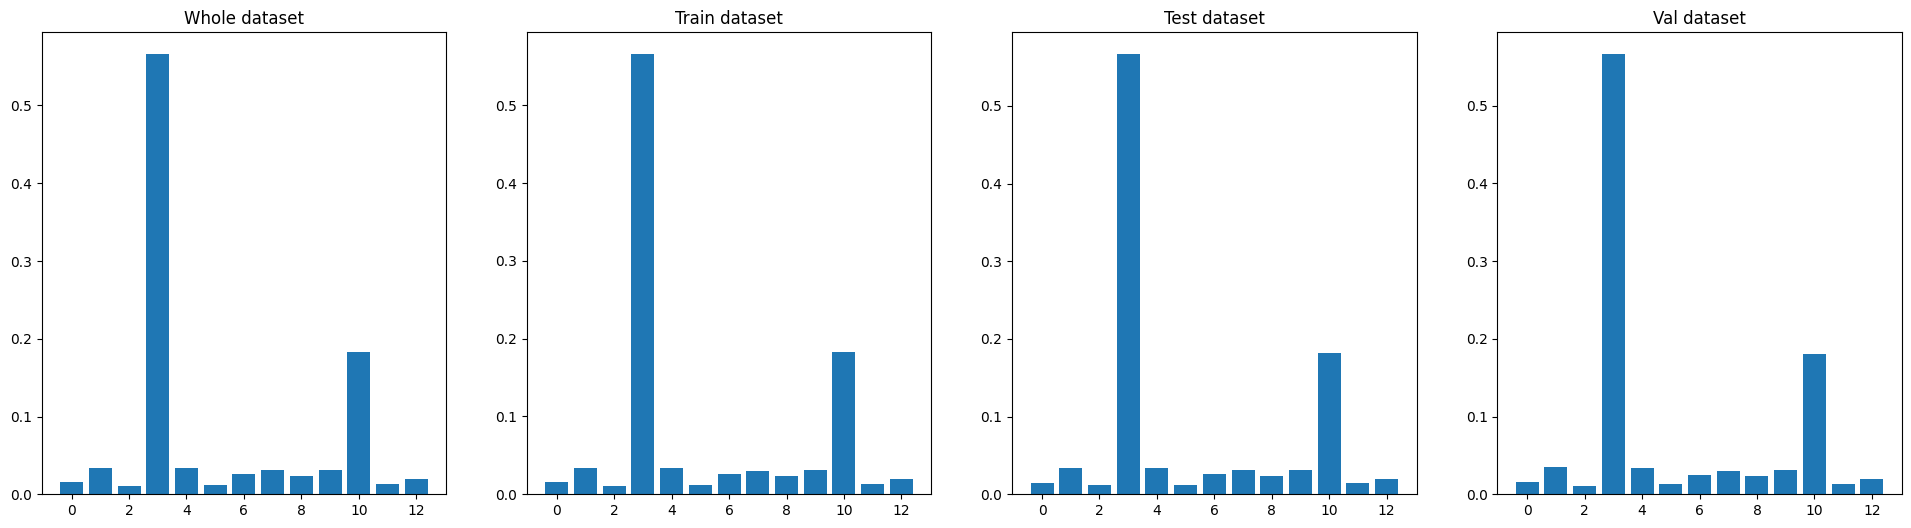

In [8]:
plot_split_stratification(dataset, train_subset, test_subset, val_subset)

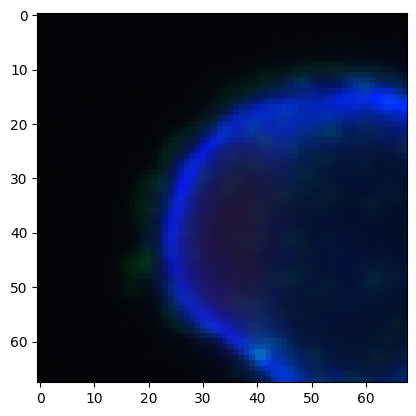

In [9]:
# get a sample image from the dataset
sample = dataset[612][0]

# show the image
show_img(sample.view(3,68,68))


In [10]:
# test to see if the shape is correct

x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([96, 3, 68, 68]) torch.Size([96])


# VAE

In [11]:
from models import VAE_LAFARGE
from loss_functions import loss_function_mean as loss_function
# from loss_functions import loss_function_elbo as loss_function

latent_dim = 2
hidden_dim = 2*latent_dim
model = VAE_LAFARGE(input_dim=(3,68,68), hidden_dim=hidden_dim, latent_dim=latent_dim)
print(model)

if cuda:
    model = model.cuda()

lr = 1e-3
# optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

# number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

VAE_LAFARGE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): BatchNorm2d(256, eps=1e-05, mo

In [12]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat = output["x_hat"]
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([96, 3, 68, 68])
x_hat.shape: torch.Size([96, 3, 68, 68])


In [13]:
# define dirs for the saving of model / data
MODEL_NAME = f"{model.__class__.__name__}_latent{model.latent_dim}_mean_"
MODEL_DIR = "trained_models/"
TRAIN_DATA_DIR = "train_data/"

print(MODEL_NAME)


VAE_LAFARGE_latent2_mean_


# Training

In [14]:
val = True

num_epochs = 50

train_loss = []
train_mse_loss = []
train_kld_loss = []
val_loss = []
val_mse_loss = []
val_kld_loss = []
best_loss = np.inf

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        output = model(x)
        x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())
        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    if val:
        model.eval()
        batch_loss = []
        batch_mse_loss = []
        batch_kld_loss = []

        with torch.no_grad():
            for x, y in val_loader:
                if cuda:
                    x = x.cuda()

                output_val = model(x)
                x_hat, mu, sigma = output_val["x_hat"], output_val["mu"], output_val["sigma"]
                loss_fn = loss_function(x, x_hat, mu, sigma)
                loss = loss_fn["loss"]
                mse_loss = loss_fn["MSE"]
                kld_loss = loss_fn["KLD"]

                batch_loss.append(loss.item())
                batch_mse_loss.append(mse_loss.item())
                batch_kld_loss.append(kld_loss.item())

            val_loss.append(np.mean(batch_loss))
            val_mse_loss.append(np.mean(batch_mse_loss))
            val_kld_loss.append(np.mean(batch_kld_loss))

            if val_loss[-1] < best_loss:
                best_loss = val_loss[-1]
                torch.save(model.state_dict(), MODEL_DIR + MODEL_NAME + "best_model.pth")



    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse_loss: {train_mse_loss[-1]}, kld_loss: {train_kld_loss[-1]}, val_loss: {val_loss[-1]}, val_mse_loss: {val_mse_loss[-1]}, val_kld_loss: {val_kld_loss[-1]}")




Epoch 1/50, loss: 256.78496468305224, mse_loss: 236.92361205023371, kld_loss: 19.861352836179293, val_loss: 206.23157576202468, val_mse_loss: 200.32300496394276, val_kld_loss: 5.908571106210094
Epoch 2/50, loss: 203.20715622206072, mse_loss: 197.1651863531766, kld_loss: 6.0419701439993725, val_loss: 201.97777821683766, val_mse_loss: 194.57709311970328, val_kld_loss: 7.400685085418476
Epoch 3/50, loss: 199.88959361367878, mse_loss: 193.7471908639653, kld_loss: 6.142402955683695, val_loss: 193.0777851826436, val_mse_loss: 187.2065025723244, val_kld_loss: 5.871282821791178
Epoch 4/50, loss: 198.73319256338655, mse_loss: 192.7190159201439, kld_loss: 6.0141768017489055, val_loss: 191.38418517241607, val_mse_loss: 185.60679030359816, val_kld_loss: 5.777394842457127
Epoch 5/50, loss: 194.43968973701817, mse_loss: 188.53277109266244, kld_loss: 5.906918690940752, val_loss: 194.37228899681597, val_mse_loss: 187.66213511249063, val_kld_loss: 6.71015409579734
Epoch 6/50, loss: 192.8551518031529, m

# Evaluate model on test set

In [15]:
# we evaluate model on test set
test_loss = []
test_mse_loss = []
test_kld_loss = []
model.eval()

for x, y in test_loader:
    if cuda:
        x = x.cuda()

    output_test = model(x)
    x_hat, mu, sigma = output_test["x_hat"], output_test["mu"], output_test["sigma"]
    loss_fn = loss_function(x, x_hat, mu, sigma)
    mse_loss = loss_fn["MSE"]
    kld_loss = loss_fn["KLD"]
    loss = loss_fn["loss"]

    test_loss.append(loss.item())
    test_mse_loss.append(mse_loss.item())
    test_kld_loss.append(kld_loss.item())

print(f"Test loss: {np.mean(test_loss)}, Test mse loss: {np.mean(test_mse_loss)}, Test kld loss: {np.mean(test_kld_loss)}")

Test loss: 176.57971344444252, Test mse loss: 170.11713720751138, Test kld loss: 6.462576344770433


# Plots

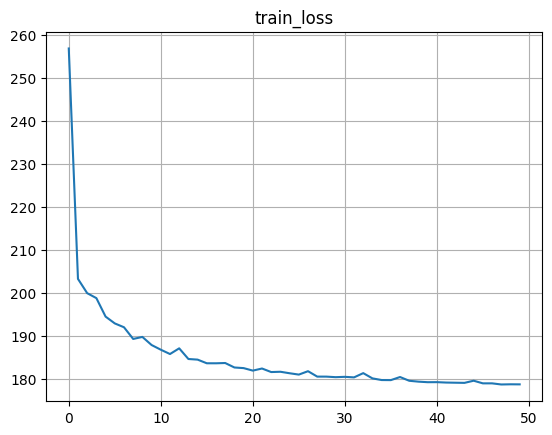

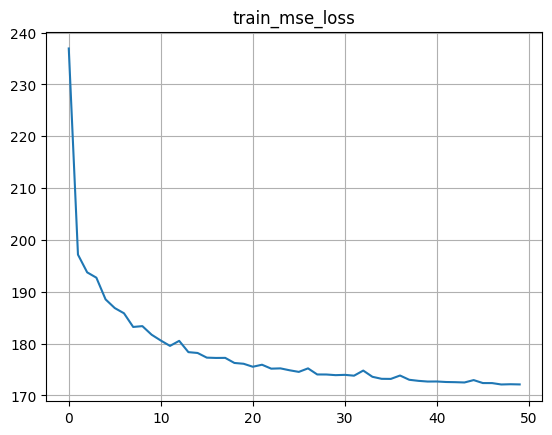

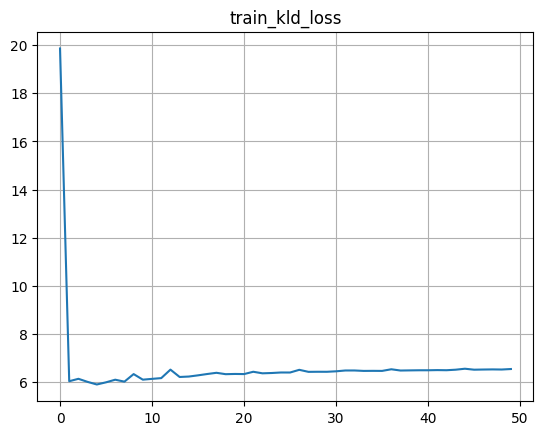

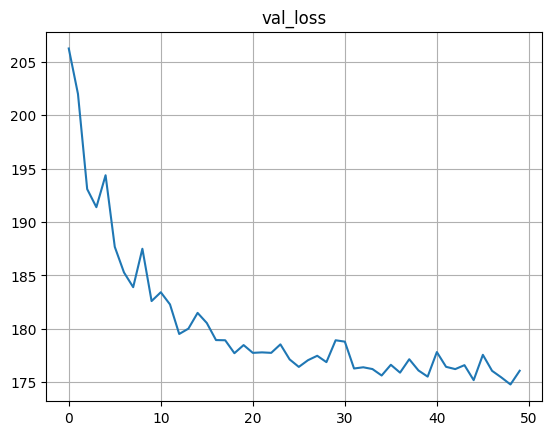

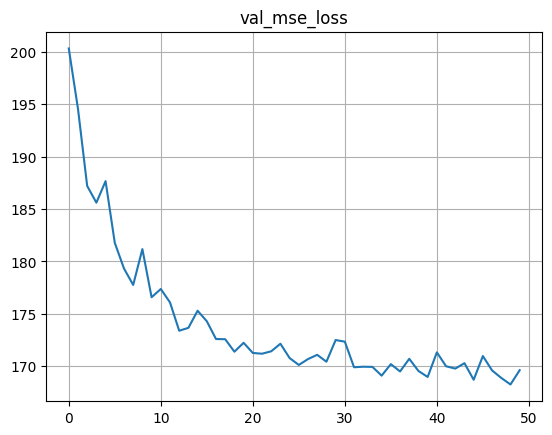

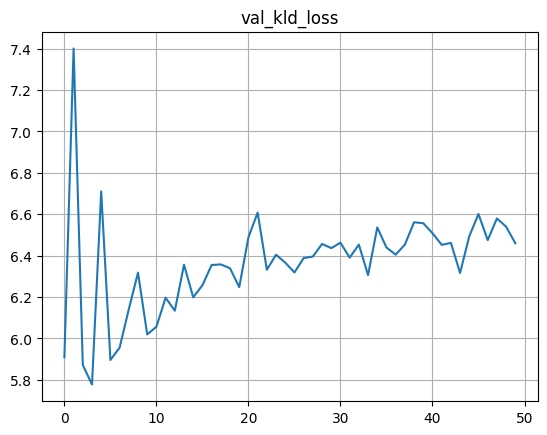

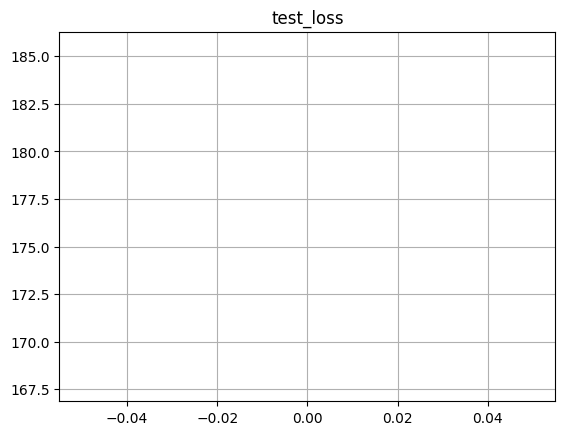

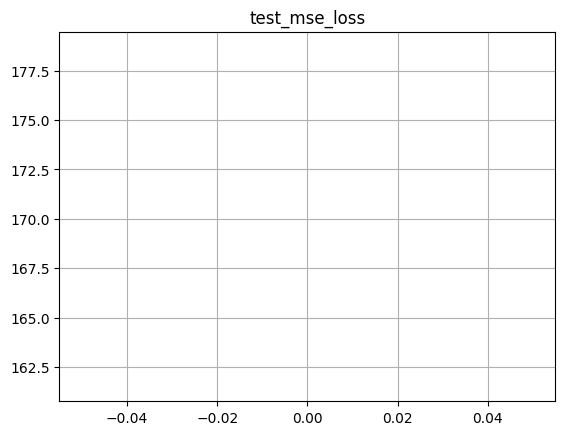

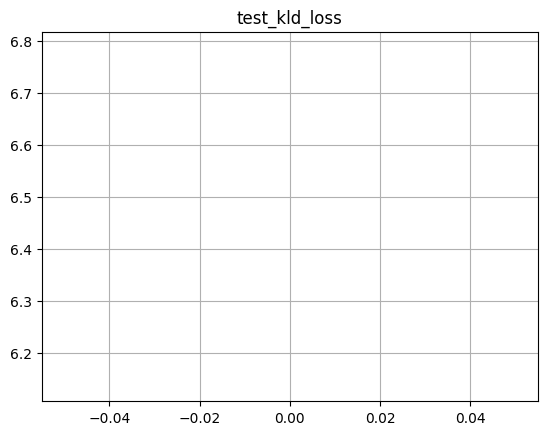

In [16]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["train_mse_loss"] = train_mse_loss
loss_data["train_kld_loss"] = train_kld_loss
loss_data["val_loss"] = val_loss
loss_data["val_mse_loss"] = val_mse_loss
loss_data["val_kld_loss"] = val_kld_loss
loss_data["test_loss"] = np.mean(test_loss)
loss_data["test_mse_loss"] = np.mean(test_mse_loss)
loss_data["test_kld_loss"] = np.mean(test_kld_loss)

loss_plots(loss_data, invidual_plots=True, title="")

df = pd.DataFrame(loss_data)
try:
    old_df = pd.read_csv(TRAIN_DATA_DIR + MODEL_NAME + "loss_data.csv")
    df = pd.concat([old_df, df])
except:
    pass
df.to_csv(TRAIN_DATA_DIR + MODEL_NAME + "loss_data.csv", index=False)


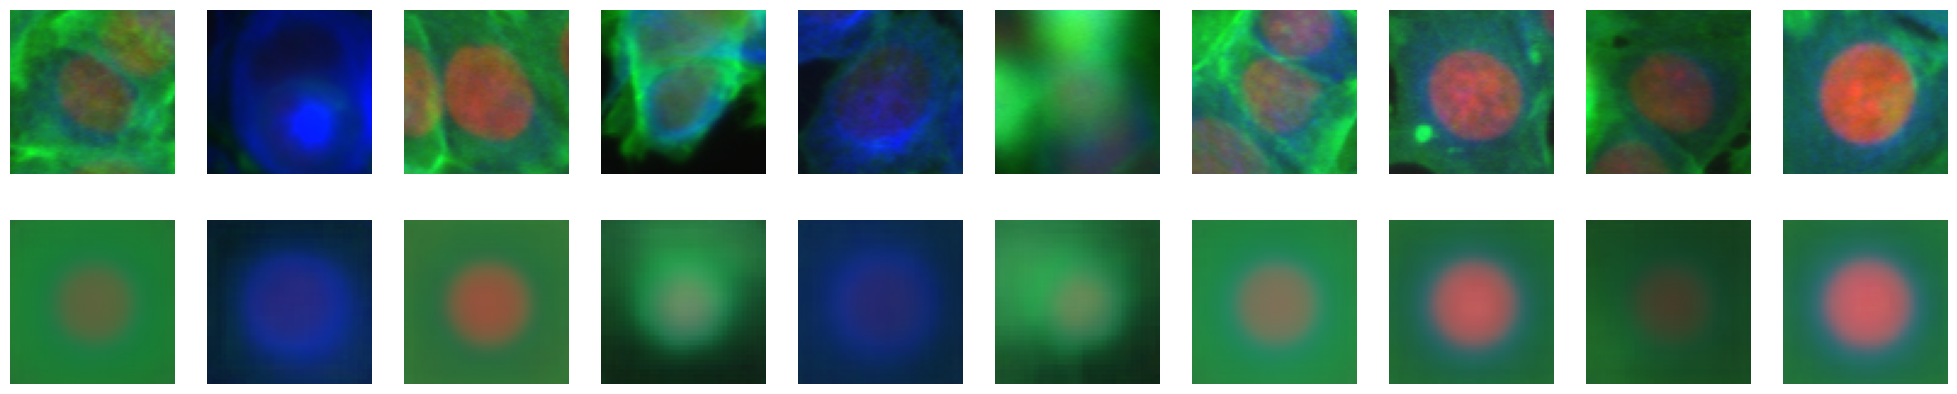

In [17]:
# test the model
plot_image_comparison(model, test_loader, cuda, img_shape=(3,68,68))
plt.savefig("VAE_LAFARGE_reconstruction_mean_1.png")

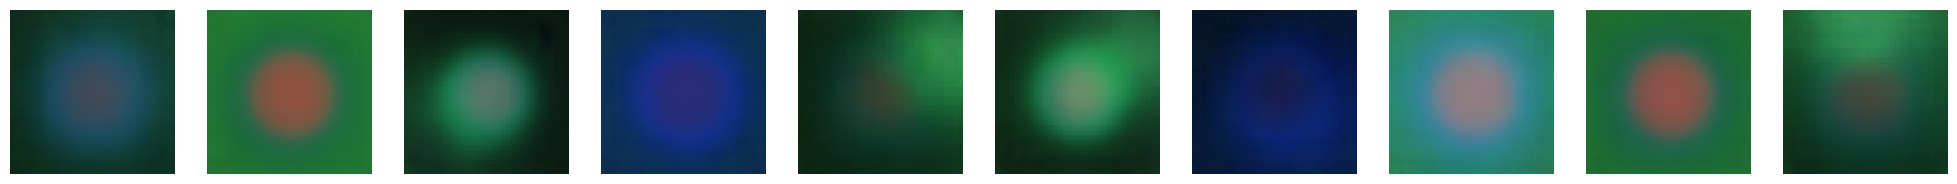

<Figure size 640x480 with 0 Axes>

In [18]:
# plot random images generated from the model
plot_random_images(model, n=10, img_shape=(3,68,68), cuda=cuda)
plt.savefig("VAE_LAFARGE_reconstruction_mean_2.png")

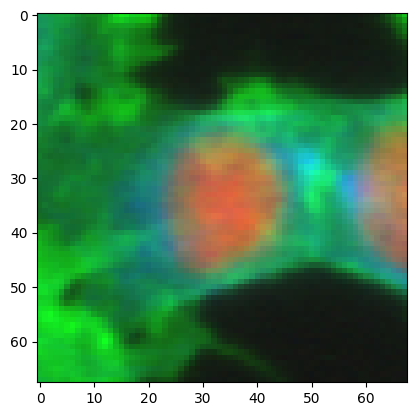

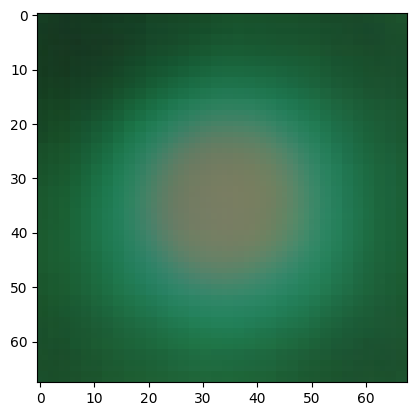

In [19]:
x, y = next(iter(test_loader))
if cuda:
    x = x.cuda()

output = model(x)

# show x
show_img(x[0].cpu().view(3,68,68))

# show x_hat
x_hat = output["x_hat"]
x_hat[0].shape

show_img(x_hat[0].cpu().detach())
